In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset

import numpy as np
import os, time, datetime, re, pathlib
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont

from torchvision import transforms
from torchvision import utils as vutils

# Variáveis e funções úteis

In [2]:
NOISE_DIM = 100
BATCH_SIZE = 128
EPOCHS = 100
IMG_SIZE = 128
LEARNING_RATE = 0.0002

transformer = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=(.5, .5, .5), std=(.5, .5, .5))
])

def get_noise(b_size_, device_ = torch.device('cpu')):
    return torch.randn((b_size_, NOISE_DIM, 1, 1), device=device_)

def create_Generator():
    return nn.Sequential(
        
        nn.ConvTranspose2d(in_channels=NOISE_DIM, out_channels=1024, kernel_size=4, stride=1, padding=0, bias=False),
        nn.BatchNorm2d(num_features=1024),
        nn.ReLU(True),
        
        nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(num_features=512),
        nn.ReLU(True),
        
        nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(num_features=256),
        nn.ReLU(True),

        nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(num_features=128),
        nn.ReLU(True),

        nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(num_features=64),
        nn.ReLU(True),

        nn.ConvTranspose2d(in_channels=64, out_channels=3, kernel_size=4, stride=2, padding=1, bias=False),
        nn.Tanh()
    )

def listar_checkpoints():
    checkpoint_list = list(pathlib.Path('./models/').glob('*.pt'))

    aux = []
    for ch in checkpoint_list:
        epoch = int(re.findall(r'[0-9]{1,}', str(ch))[0])
        aux.append([str(ch), epoch])
    
    # ordernar por epoch mais antiga em primeiro
    aux = sorted([[ch, ep] for ch, ep in aux], key=lambda item:item[1], reverse=True)
    
    return aux

# Importando o modelo e carregando os pesos treinados

In [44]:
checkpoint_path, last_epoch = listar_checkpoints()[0]
print (f'{last_epoch=}')
generator = create_Generator()
checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
print (generator.load_state_dict(checkpoint['generator_state_dict']))
generator.eval()

last_epoch=8
<All keys matched successfully>


Sequential(
  (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU(inplace=True)
  (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU(inplace=True)
  (12): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (13): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, t

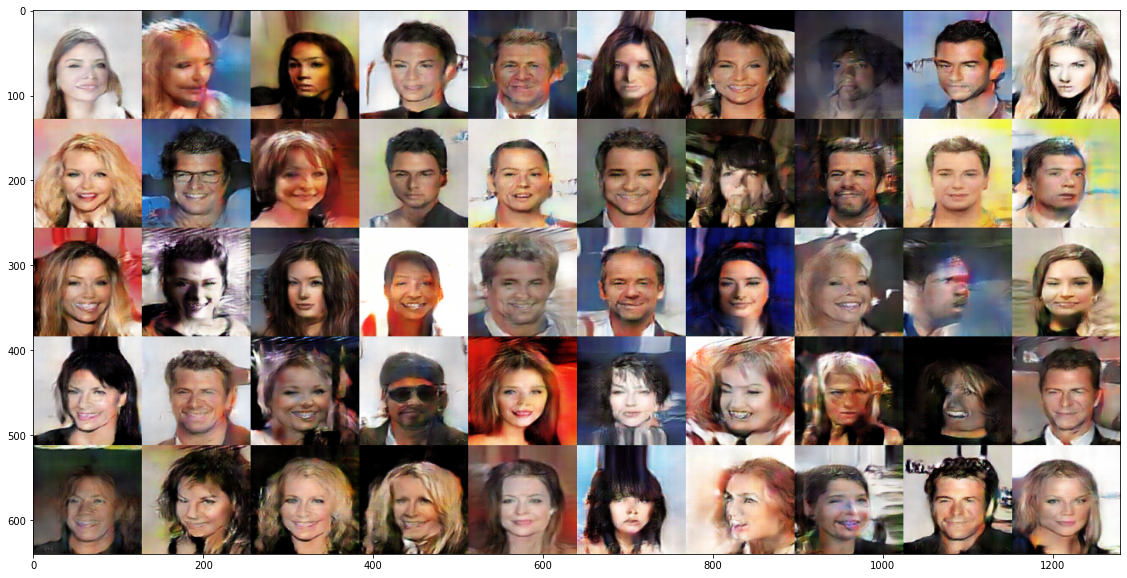

In [54]:
noise = get_noise(50)
imgs = generator(noise)
grid_tensor = vutils.make_grid(imgs, nrow=10, padding=0, normalize=True)
grid_np = np.transpose(grid_tensor.detach().cpu().numpy(), (1, 2, 0))
plt.figure(figsize=(20, 10))
plt.imshow(grid_np)
plt.show()

# Vamos escolher algumas imagens acima para fazer a interpolação

In [55]:
vetor = np.array([imgs[v].detach().cpu().numpy() for v in [9, 10, 39, 48]])

(4, 3, 128, 128)